# Parameter sensitivity study - loop 04


Parameter sensitivity study - Loop 4 was performed for random board states available in library that have more than 50 free fields. n=100 repetitions for each set.

Parameter sets tested:

                    99.9%, 99%, 97%, 95%
conf_level_values = [3.29, 2.58, 2.17, 1.96]

margin_estim_values = [1.00]

margin_highest_values = [0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20, 0.22, 0.24, 0.26, 0.28, 0.30]

# Load result files

Load the sensitivity study results file from loop 02

In [32]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1700)
pd.set_option('display.max_columns', 20)
pd.set_option('max_colwidth', 2000)

param_sens_study_dir = "param_sens_study\\L04"
param_sens_study_file = "param_sens_study_file_n100.csv"
param_sens_study_path = os.path.join(param_sens_study_dir, param_sens_study_file)

df = pd.read_csv(param_sens_study_path)
print(df.dtypes)

print('Results loaded for the following board states:')
print(df['board_state_100chars_code'].unique())



board_state_100chars_code     object
conf_level                   float64
margin_est                   float64
margin_highest               float64
rel_error                    float64
time_mc                      float64
dtype: object
Results loaded for the following board states:
['0000070000000000000010000000000700000007707000007007070007077777777070755555707077777777070707333700'
 '4444755555777777777707270077770727007227777700777700007000000007000000007000000700000000000000000000'
 '7700000000570000000057000000005700000000570000070057000070007700070077777770077344447070737777700773'
 '7773337000577777707057070007075770000070570000000057000007777700000747000000074700000007470070007747'
 '0000070000000000000000077777770007555557700777777700007370000000737000000073700000007777770000707333'
 '0000744447700777777707775707000727570070772757000707775700000007570000000777000000000000000000070000'
 '0007000700707000707707007000750007070075700070777500000073750000007375700007737707777077700

Load 'times_adv' file, which contains data about calculation time using advanced algorithm

In [33]:
times_adv_dir = "times_adv\\"
times_adv_file = "times_adv_file.npy"
times_adv_path = os.path.join(times_adv_dir, times_adv_file)

adv_times_numpy = np.load(times_adv_path)

adv_times_df = pd.DataFrame(adv_times_numpy)
adv_times_df.columns = ['board_state_100chars_code', 'time_adv']
adv_times_df['time_adv'] = adv_times_df['time_adv'].apply(pd.to_numeric, errors='coerce')

print(adv_times_df.sample(5))


                                                                                 board_state_100chars_code  time_adv
399   0000737227000073777777777370707227777700777700700777777700775555570774777777007400707777740700733374      0.02
3296  7333777777777777444477700777777270777000727075777777707572270000757777000775700000007577770000777227      0.02
4843  0007227000000777700000707777770700744447777777777773337000007777700000000007000000000710000000700000      6.12
2883  2773337757277777775777707007572270070757777770775700747707770074707000777477007000747077770077707333      0.02
229   0007075700700007577001000757070000775770000007570770000777770007777773000733377300077777730070070077      6.45


# Count and visualize inconsistent results

Results are inconsistent if the relative error in probabilistic method (MC) is higher than defined margin_highest parameter. That can happen with low confidence level.

Let's investigate how often it happens depending on confidence level used. Additionaly, average exceedance (in %) of allowed margin_highest is calculated for those cases.

   conf_level  inc_count  avg_perc_exceedance  total  perc_inc
0        1.96          8                  5.0  57200      0.01
1        2.17          1                  0.0  57200      0.00
2        2.58          0                  NaN  57200      0.00
3        3.29          0                  NaN  59800      0.00


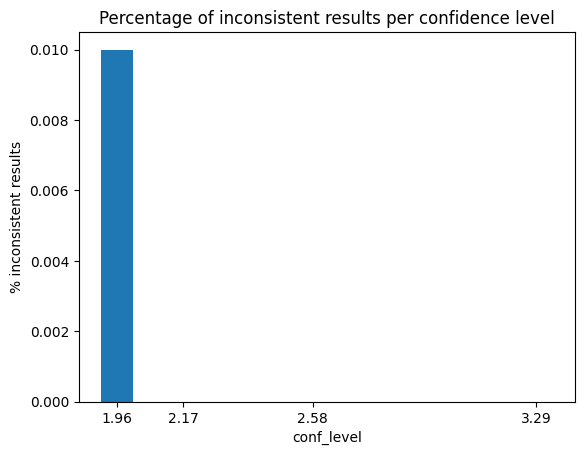

In [34]:
tot_per_conf = df.groupby('conf_level', as_index=False).count()

df['is_inconsistent'] = (df['rel_error'] > df['margin_highest'])
df['exceedance'] = np.where(df['rel_error'] > df['margin_highest'],
                            (df['rel_error'] / df['margin_highest'] - 1) * 100,
                            np.nan)

inc_plot = df.groupby('conf_level', as_index=False).agg(
    inc_count = ('is_inconsistent', 'sum'),
    avg_perc_exceedance = ('exceedance', 'mean')
)

inc_plot['total'] = inc_plot['conf_level'].map(tot_per_conf.set_index('conf_level')['rel_error'])
inc_plot['perc_inc'] = inc_plot['inc_count'] / inc_plot['total'] * 100

inc_plot['avg_perc_exceedance'] = inc_plot['avg_perc_exceedance'].round(0)
inc_plot['perc_inc'] = inc_plot['perc_inc'].round(2)
print(inc_plot)

###### PLOT INCONSISTENT RESULTS PER CONF_LEVEL #######
plt.bar(inc_plot['conf_level'], inc_plot['perc_inc'], width=0.1)
plt.title('Percentage of inconsistent results per confidence level')
plt.xlabel('conf_level')
plt.ylabel("% inconsistent results")
plt.xticks(inc_plot['conf_level'])
plt.show()


Not many inconsistencies - that's good!

# Aggregate & Normalize

##### Aggregate series of repetitive runs for the same board_state and parameters



In [35]:
def aggregate_results(df):
    avg_res = df.groupby(['board_state_100chars_code', 'conf_level', 'margin_est', 'margin_highest'], as_index=False).agg(
        rel_error = ('rel_error', 'mean'),
        time_mc = ('time_mc', 'mean'),
        max_error = ('rel_error', 'max'),
        )
    return avg_res

avg_res = aggregate_results(df)
print(avg_res.sample(5))


                                                                                 board_state_100chars_code  conf_level  margin_est  margin_highest  rel_error  time_mc  max_error
1131  0007000700000000700000000000770000000072700000777200700075770007777570000737757000073775700007377570        3.29         1.0            0.06   0.002242  14.6232    0.02038
2092  4444755555777777777707270077770727007227777700777700007000000007000000007000000700000000000000000000        3.29         1.0            0.30   0.025614   0.5076    0.12450
465   0000070000000000000010000000000700000007707000007007070007077777777070755555707077777777070707333700        3.29         1.0            0.26   0.003494   3.5392    0.05823
1834  0700755555777777777774733370077477777070747000070774700000707770000007000000000007000000001007000000        2.17         1.0            0.08   0.000698   3.7464    0.06983
420   0000070000000000000010000000000700000007707000007007070007077777777070755555707077777777070707333700    

##### Normalize average error to 0.5%

Normalization is necessary in order to aggregate and compare data from different board states 


0.5% is an acceptable level of average error, that I will use as a reference point and compare rest of results to it.

error_normalized is expressed as % of 0.5% error


In [36]:
avg_res['error_normalized'] = avg_res['rel_error'] / 0.005 * 100


##### Normalize time
For each board state find minimum time_mc for which ['error_normalized'] < 100. This will be reference time

time_normalized is expressed as % of time needed to achieve reference point error (0.5%)

For example, time_normalized = 200 means it takes twice as long as reference, so we should expect lower error

Additionally, attach a new column with information about time_adv for each board state

In [37]:
def normalize_time(avg_res):

    avg_res_per_game = avg_res.loc[(avg_res['error_normalized'] < 100)]

    avg_res_per_game = avg_res_per_game.groupby(['board_state_100chars_code'], as_index=False).agg(
        time_at_100_error = ('time_mc', 'min'),
        )

    # Map 'time_at_100_error' and 'time_adv' to original avg_res dataframe
    avg_res['time_at_100_error'] = avg_res['board_state_100chars_code'].map(avg_res_per_game.set_index('board_state_100chars_code')['time_at_100_error'])
    avg_res['time_adv'] = avg_res['board_state_100chars_code'].map(adv_times_df.set_index('board_state_100chars_code')['time_adv'])

    # Normalize 'time_mc' as percentage of 'time_at_100_error'
    avg_res['time_normalized'] = avg_res['time_mc'] / avg_res['time_at_100_error'] * 100

    # Normalize advanced time as percentage of 'time_at_100_error'
    avg_res['time_adv'] = avg_res['board_state_100chars_code'].map(adv_times_df.set_index('board_state_100chars_code')['time_adv'])
    avg_res['time_adv_normalized'] = avg_res['time_adv'] / avg_res['time_at_100_error'] * 100

    return avg_res

avg_res = normalize_time(avg_res)
print(avg_res.sample(20))

                                                                                 board_state_100chars_code  conf_level  margin_est  margin_highest  rel_error  time_mc  max_error  error_normalized  time_at_100_error  time_adv  time_normalized  time_adv_normalized
1835  0700755555777777777774733370077477777070747000070774700000707770000007000000000007000000001007000000        2.17         1.0            0.10   0.003492   2.4808    0.06983            69.830             1.7130     51.98       144.821950          3034.442499
1557  0070070000777777000074444707007777777000000733300000007770000000000070777700000022700000007770700000        3.29         1.0            0.26   0.008581   0.5023    0.09967           171.628             0.5958     24.47        84.306814          4107.082914
2069  4444755555777777777707270077770727007227777700777700007000000007000000007000000700000000000000000000        2.58         1.0            0.10   0.007567   2.3634    0.05699           151.334             3.6

# Create score metrics

Set up a score metrics which promotes those parameters' sets which roduce results more accurately and faster than reference set.

3 similar metrics are created, differing in weights assigned to precision increase and time decrease.

I leave it open to decide whether I care more about optimizing precision or calculation time (approach may vary dependingo on board state for example)



In [38]:
def calc_score(avg_res):
    t_norm = avg_res['time_normalized']
    t_value = avg_res['time_mc']
    e_norm = avg_res['error_normalized']

    change_in_error = (e_norm - 100)  # Increases score if negative
    change_in_time = (t_norm - 100)   # Increases score if negative
    time_vs_error_factor = 1          # How much more we care about precision increase than time decrease

    # Main score metrics by which results will be sorted
    avg_res['score'] = -1 * (change_in_error * time_vs_error_factor + change_in_time)

    # Different variants to compare
    avg_res['score_1'] = -1 * (change_in_error * 1 + change_in_time)
    avg_res['score_2'] = -1 * (change_in_error * 2 + change_in_time)
    avg_res['score_4'] = -1 * (change_in_error * 4 + change_in_time)

    return avg_res

avg_res = calc_score(avg_res)
print(avg_res.sample(10))

                                                                                 board_state_100chars_code  conf_level  margin_est  margin_highest  rel_error  time_mc  max_error  error_normalized  time_at_100_error  time_adv  time_normalized  time_adv_normalized       score     score_1     score_2      score_4
64    0000070000000000000000000000000000000000700000000777700011007377777770737555557073777777707772270000        1.96         1.0            0.30   0.019834   0.2381    0.07346           396.684             0.5703     70.09        41.749956         12290.022795 -238.433956 -238.433956 -535.117956 -1128.485956
348   0000070000000000000000077777770007555557700777777700007370000000737000000073700000007777770000707333        2.58         1.0            0.26   0.004302   0.4336    0.16677            86.032             0.2966    121.35       146.190155         40913.688469  -32.222155  -32.222155  -18.254155     9.681845
327   0000070000000000000000077777770007555557700777777700007370

# Group by parameters

Group by unique parameters set, average across board_states

(searching for parameters set that in universally good, not only in one specific game setup)

In [39]:
def group_by_parameters(avg_res):
    avg_res = avg_res.groupby(['conf_level', 'margin_est', 'margin_highest'], as_index=False).agg(
        max_error = ('max_error', 'max'),
        avg_error_normalized = ('error_normalized', 'mean'),
        avg_time_normalized = ('time_normalized', 'mean'),
        avg_score = ('score', 'mean'),
        avg_score_1 = ('score_1', 'mean'),
        avg_score_2 = ('score_2', 'mean'),
        avg_score_4 = ('score_4', 'mean'),
        )

    return avg_res

avg_res = group_by_parameters(avg_res)
print(avg_res.sample(10).sort_values(by = 'avg_score'))

    conf_level  margin_est  margin_highest  max_error  avg_error_normalized  avg_time_normalized   avg_score  avg_score_1  avg_score_2  avg_score_4
26        2.58         1.0            0.06    0.04598             15.933727          1159.964856 -975.898584  -975.898584  -891.832311  -723.699766
14        2.17         1.0            0.08    0.07346             37.197136           471.700504 -308.897640  -308.897640  -246.094777  -120.489049
44        3.29         1.0            0.16    0.10010             56.215111           295.844491 -152.059602  -152.059602  -108.274713   -20.704936
45        3.29         1.0            0.18    0.10010             64.183778           239.068096 -103.251874  -103.251874   -67.435652     4.196793
21        2.17         1.0            0.22    0.17572            216.026727            77.418606  -93.445333   -93.445333  -209.472061  -441.525515
46        3.29         1.0            0.20    0.10010             83.296222           197.456900  -80.753123   -

# Filter results

Discard those parameters which produce unsatisfactory results

In [40]:
def filter_results(avg_res):
    # Discard parameters which resulted in max_error higher than 25%
    reduced = avg_res.query('max_error < 0.25')

    # Discard parameters below given score metrics
    sc_limit = -500
    reduced = reduced.query('avg_score_1 >= @sc_limit & avg_score_2 >= @sc_limit & avg_score_4 >= @sc_limit & avg_time_normalized < 5000')

    # Discard confidence levels that produce inconsintent results
    reduced = reduced.query('conf_level >= 1.96')

    return reduced

reduced = filter_results(avg_res)
print('reduced results - sorted by score')
print(reduced.sort_values(by = 'avg_score'))

reduced results - sorted by score
    conf_level  margin_est  margin_highest  max_error  avg_error_normalized  avg_time_normalized   avg_score  avg_score_1  avg_score_2  avg_score_4
0         1.96         1.0            0.06    0.06983             25.663682           673.297935 -498.961617  -498.961617  -424.625299  -275.952662
27        2.58         1.0            0.08    0.06879             25.543955           664.553159 -490.097114  -490.097114  -415.641068  -266.728977
42        3.29         1.0            0.12    0.09691             33.755822           504.624021 -338.379843  -338.379843  -272.135665  -139.647310
14        2.17         1.0            0.08    0.07346             37.197136           471.700504 -308.897640  -308.897640  -246.094777  -120.489049
28        2.58         1.0            0.10    0.07346             39.206864           434.657549 -273.864412  -273.864412  -213.071276   -91.485003
1         1.96         1.0            0.08    0.08233             44.414500   

At this point I had 2 main doubts:
1. Is linear mean really approppriate for averaging the error across repetitions? Should I not use quadratic mean instead?

2. How varying reference error level (currently set to 0.5%) influences the results scoring?

Dealing with point 1 is a subjective matter. Choosing to go with quadratic mean puts more emphasis on the outliers. That way, more 'stable' parameter sets are preferred than those that might be better on linear average, but can occasionally produce very high error (chance is low, but if it can happen, it eventually will - thinking of thousands / millions of calculations ahead).

See the difference with quadratic mean applied below, in terms of final scoring:


In [41]:
def aggregate_results_quadratic(df):
    avg_res = df.groupby(['board_state_100chars_code', 'conf_level', 'margin_est', 'margin_highest'], as_index=False).agg(
        rel_error = ('rel_error', lambda x: np.sqrt(np.mean(np.square(x)))),
        time_mc = ('time_mc', 'mean'),
        max_error = ('rel_error', 'max'),
        )
    return avg_res

avg_res = aggregate_results_quadratic(df)
avg_res['error_normalized'] = avg_res['rel_error'] / 0.005 * 100
avg_res = normalize_time(avg_res)
avg_res = calc_score(avg_res)
avg_res = group_by_parameters(avg_res)
reduced = filter_results(avg_res)
print('reduced results - sorted by score')
print(reduced.sort_values(by='avg_score'))

reduced results - sorted by score
    conf_level  margin_est  margin_highest  max_error  avg_error_normalized  avg_time_normalized   avg_score  avg_score_1  avg_score_2  avg_score_4
13        2.17         1.0            0.06    0.05196             53.229352           584.174322 -424.877228  -424.877228  -365.580133  -246.985945
41        3.29         1.0            0.10    0.06983             60.137478           514.033000 -363.310022  -363.310022  -312.587043  -211.141086
0         1.96         1.0            0.06    0.06983             63.480138           482.571946 -334.210384  -334.210384  -285.848822  -189.125699
27        2.58         1.0            0.08    0.06879             67.031084           476.565801 -332.006855  -332.006855  -287.447910  -198.330019
42        3.29         1.0            0.12    0.09691             89.665702           366.499021 -243.418951  -243.418951  -220.338882  -174.178743
14        2.17         1.0            0.08    0.07346             97.526799   

Now, [2.17, 1.0, 0.10] is higher ranked than [2.17, 1.0, 0.12]. It was the opposite with linear mean.
This must be because the set with 0.12 produced enough high outliers (up to max error of 0.09725) to greatly increase the quadratic mean, while 0.10 parameter set was not so much affected.

I think quadratic mean is the right way to go. All futher data processing will be using it.


Now let's deal with the doubt number 2

Here we repeat the normalization process with different reference error levels and compare the reduced results sorted by score:

In [42]:
# 0.25%
avg_res = aggregate_results_quadratic(df)
avg_res['error_normalized'] = avg_res['rel_error'] / 0.0025 * 100
avg_res = normalize_time(avg_res)
avg_res = calc_score(avg_res)
avg_res = group_by_parameters(avg_res)
reduced = filter_results(avg_res)
print('reduced results - sorted by score')
print(reduced.sort_values(by='avg_score'))

reduced results - sorted by score
    conf_level  margin_est  margin_highest  max_error  avg_error_normalized  avg_time_normalized   avg_score  avg_score_1  avg_score_2  avg_score_4
13        2.17         1.0            0.06    0.05196            106.458704           636.878322 -485.197030  -485.197030  -433.515737  -330.153153
41        3.29         1.0            0.10    0.06983            120.274957           562.582135 -426.613585  -426.613585  -390.645036  -318.707937
27        2.58         1.0            0.08    0.06879            134.062169           520.980412 -396.118790  -396.118790  -371.257168  -321.533925
0         1.96         1.0            0.06    0.06983            126.960277           527.556957 -386.720393  -386.720393  -345.883829  -264.210702
42        3.29         1.0            0.12    0.09691            179.331405           401.021825 -316.195567  -316.195567  -331.369309  -361.716792
14        2.17         1.0            0.08    0.07346            195.053597   

In [43]:
# 1.00%
avg_res = aggregate_results_quadratic(df)
avg_res['error_normalized'] = avg_res['rel_error'] / 0.01 * 100
avg_res = normalize_time(avg_res)
avg_res = calc_score(avg_res)
avg_res = group_by_parameters(avg_res)
reduced = filter_results(avg_res)
print('reduced results - sorted by score')
print(reduced.sort_values(by='avg_score'))

reduced results - sorted by score
    conf_level  margin_est  margin_highest  max_error  avg_error_normalized  avg_time_normalized   avg_score  avg_score_1  avg_score_2  avg_score_4
41        3.29         1.0            0.10    0.06983             30.068739           622.235098 -452.303837  -452.303837  -382.372576  -242.510055
0         1.96         1.0            0.06    0.06983             31.740069           588.621269 -420.361338  -420.361338  -352.101407  -215.581546
27        2.58         1.0            0.08    0.06879             33.515542           581.156356 -414.671898  -414.671898  -348.187440  -215.218525
42        3.29         1.0            0.12    0.09691             44.832851           442.613392 -287.446243  -287.446243  -232.279095  -121.944797
14        2.17         1.0            0.08    0.07346             48.763399           412.378501 -261.141901  -261.141901  -209.905300  -107.432098
28        2.58         1.0            0.10    0.07346             49.385180   

It is as I worried - highly dependent on reference level, which is a subjective choice. We can make use of this normalization to determine optimal parameters for the tolerated level of precision - could differ depending on what we want to calculate. Maybe I can find a use for that in future when I have even more data, enough to differentiate between board states based on some criteria (number of certain ships sunk, number of hit-unsunk, other deciding factors?) to choose the best suited set of parameters for given situation.

But for now, let's make it simpler and try to find more generally optimal parameters. For this, I will resign from normalization by certain error value, in favor of MaxScaling the relative results - that is, representing it as % of maximum error calculated <u>for the particular board state</u> using all examined parameter sets.

In [44]:
def scale_results(avg_res):
    avg_res_per_code = avg_res.groupby(['board_state_100chars_code'], as_index=False).agg(
    max_error_per_code = ('rel_error', 'max'),
    max_time_per_code = ('time_mc', 'max'),
    )
    # Map 'max_error_per_code' and 'max_time_per_code' to original avg_res dataframe
    avg_res['max_error_per_code'] = avg_res['board_state_100chars_code'].map(avg_res_per_code.set_index('board_state_100chars_code')['max_error_per_code'])
    avg_res['max_time_per_code'] = avg_res['board_state_100chars_code'].map(avg_res_per_code.set_index('board_state_100chars_code')['max_time_per_code'])

    # Drop board state codes where max_error_per_code is 0
    avg_res = avg_res.query('max_error_per_code > 0')

    # Normalize error and time as percentage of their max values per game code
    avg_res['error_normalized'] = avg_res['rel_error'] / avg_res['max_error_per_code'] * 100
    avg_res['time_normalized'] = avg_res['time_mc'] / avg_res['max_time_per_code'] * 100

    return avg_res

# Repeat whole process with scaling instead of normalizing
avg_res = aggregate_results_quadratic(df)
avg_res = scale_results(avg_res)
avg_res = calc_score(avg_res)
avg_res = group_by_parameters(avg_res)
reduced = filter_results(avg_res)
print('reduced results - sorted by score')
print(reduced.sort_values(by='avg_score'))



reduced results - sorted by score
    conf_level  margin_est  margin_highest  max_error  avg_error_normalized  avg_time_normalized   avg_score  avg_score_1  avg_score_2  avg_score_4
39        3.29         1.0            0.06    0.03092              6.999966           100.000000   93.000034    93.000034   186.000069   372.000137
12        1.96         1.0            0.30    0.21905             91.489355             1.828927  106.681718   106.681718   115.192362   132.213652
11        1.96         1.0            0.28    0.22644             84.112748             2.042953  113.844299   113.844299   129.731552   161.506057
10        1.96         1.0            0.26    0.22674             81.322829             2.325938  116.351232   116.351232   135.028403   172.382745
25        2.17         1.0            0.30    0.24106             79.901099             2.206389  117.892512   117.892512   137.991413   178.189216
24        2.17         1.0            0.28    0.24739             73.829122   

C:\Users\Czeremis\AppData\Local\Temp\ipykernel_6580\149238730.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_res['error_normalized'] = avg_res['rel_error'] / avg_res['max_error_per_code'] * 100
C:\Users\Czeremis\AppData\Local\Temp\ipykernel_6580\149238730.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_res['time_normalized'] = avg_res['time_mc'] / avg_res['max_time_per_code'] * 100


Combinations of conf_level = [2.17, 2.58] with margin_highest = [0.10, 0.12] are best with scaling method, and they also are among the highest ranked with 0.5% normalization. That is suprisingly good news, because my original plan was to aim at 0.5% normalization anyway, and that just happens to be in line with globally efficient parameters.

Out of the top3 I like [2.17, 1.0, 0.10] the most, simply because the maximum error is lowest there, while average error and time are very comparable. These few % differences are IMO worth the additional safety against the higher errors. Regarding [3.29, 1.0, 0.18], though numbers show the results are similar, I mistrust this a bit because of margin_highest = 0.18. I am worried that when given more tries, it might eventually produce an error up to 18% without being "inconsistent". Better have this limit at lower value, otherwise it's a gamble.

## Scatter plot - reduced results

Simple plot of MaxScaled error vs time for filetered data points, focused on the best region with hightighted "winner set"

Color map:  higher score = lower transparency

Orange marker: conf_level == 2.58 and margin_est == 1 and margin_highest == 0.12

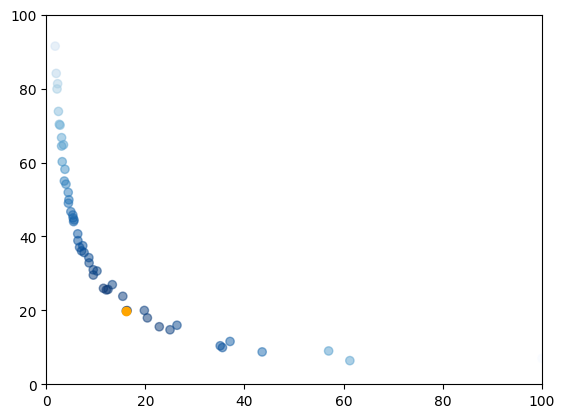

In [45]:
x = reduced['avg_time_normalized']
y = reduced['avg_error_normalized']
plt.xlim([0,100])
plt.ylim([0,100])
c  =  reduced['avg_score']

plt.scatter(x, y, c=c, alpha=0.5, cmap='Blues')

orange_highlight_condition = 'conf_level == 2.58 and margin_est == 1 and margin_highest == 0.12'
orange_highlight = reduced.query(orange_highlight_condition)
plt.scatter(orange_highlight.avg_time_normalized, orange_highlight.avg_error_normalized, marker='o', color='orange')

plt.show()


## Plots for multiple board states

Let's take a broader view on how parameter sets behave in each board state individually (without averagin across multiple board states).

We will see if out top3 paremater sets (highlighted with different color markers) are always best suited, or there is no clear rule and the detemination of winner is purely statistical thing.


In [51]:
# Repeat whole process with scaling instead of normalizing and without grouping by parameters
avg_res = aggregate_results_quadratic(df)
avg_res = scale_results(avg_res)

# For each board state code create scatter plot of rel_error vs time_mc per parameter set
red_highlight_condition = 'conf_level == 2.17 and margin_est == 1 and margin_highest == 0.10'
green_highlight_condition = 'conf_level == 2.58 and margin_est == 1 and margin_highest == 0.10'
orange_highlight_condition = 'conf_level == 2.58 and margin_est == 1 and margin_highest == 0.12'

plt.figure(figsize=(18, 12))
plt.suptitle('Scatter Plots of rel_error vs time_mc for Each Board State Code\n ' \
'red-highlighted parameter set: ' + red_highlight_condition + '\n'
'green-highlighted parameter set: ' + green_highlight_condition + '\n'
'orange-highlighted parameter set: ' + orange_highlight_condition + '\n'
, fontsize=12)

i = 1
for name, group in avg_res.groupby('board_state_100chars_code'):
    plt.subplot(5, 8, i)

    temp_df = avg_res.query('board_state_100chars_code == @name')
    plt.scatter(temp_df.time_normalized, temp_df.error_normalized, marker='o', color='black', s=5)

    red_highlight = temp_df.query(red_highlight_condition)
    green_highlight = temp_df.query(green_highlight_condition)
    orange_highlight = temp_df.query(orange_highlight_condition)
    plt.scatter(red_highlight.time_normalized, red_highlight.error_normalized, marker='x', color='red', s=50)
    plt.scatter(green_highlight.time_normalized, green_highlight.error_normalized, marker='x', color='green', s=50)
    plt.scatter(orange_highlight.time_normalized, orange_highlight.error_normalized, marker='x', color='orange', s=50)

    i +=1

plt.show()

C:\Users\Czeremis\AppData\Local\Temp\ipykernel_6580\149238730.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_res['error_normalized'] = avg_res['rel_error'] / avg_res['max_error_per_code'] * 100
C:\Users\Czeremis\AppData\Local\Temp\ipykernel_6580\149238730.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_res['time_normalized'] = avg_res['time_mc'] / avg_res['max_time_per_code'] * 100


## The End

View of these 40 plots are a great way to conclude and summarize the whole study, or at least its first edition focused on finding the one universally good paremater set.

I already began to see the winning parameter sets after 24 board states calculated and from that point most of them stayed on top till the end. I decided that 40 samples has to be enough, so I can stop torturing my PC and proceed with the project. 